In [ ]:
import numpy as np
import pandas as pd
import os
import mne
import matplotlib.pyplot as plt

%matplotlib qt

Channels marked as bad:
none
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


# De-CRAT

In [3]:
eeg_path = "C:\\Users\\a1902989\\Box\\Katya\\# PD project\\pilot\\eeg"
eeg_file_name = "PDc_s1_sub00_GR_DeCRAT.vhdr"
raw = mne.io.read_raw_brainvision(os.path.join(eeg_path, eeg_file_name), preload=True)
raw.info

Extracting parameters from C:\Users\a1902989\Box\Katya\# PD project\pilot\eeg\PDc_s1_sub00_GR_DeCRAT.vhdr...
Setting channel info structure...
Reading 0 ... 1245039  =      0.000 ...  2490.078 secs...


C:\Users\a1902989\AppData\Local\Temp\ipykernel_33384\746842245.py:3: RuntimeWarning: No coordinate information found for channels ['Photodiode', 'Acc X', 'Acc Y', 'Acc Z', 'EMG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(os.path.join(eeg_path, eeg_file_name), preload=True)
C:\Users\a1902989\AppData\Local\Temp\ipykernel_33384\746842245.py:3: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['Photodiode', 'Acc X', 'Acc Y', 'Acc Z', 'EMG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(os.path.join(eeg_path, eeg_file_name), preload=True)


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG, 5 misc
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 131.0 Hz
 meas_date: 2026-01-27 10:42:13 UTC
 nchan: 69
 projs: []
 sfreq: 500.0 Hz
>

**Prep for epoching: Read events and annotate bad trials**

In [4]:
# 1 = practice block
# 2 = baseline block
# 3-4 = adaptation blocks
# 5 = post-adaptation block
# 6-7 = deadaptation blocks
# 8 = trial start
# 9 = trial end
# 20 = prepare signal (target onset)
# 30 = go signal
# 40 = reach end
# 50 = movement onset
# 77 - BAD trial: too late
# 111 - BAD trial: too soon

events_dict = mne.events_from_annotations(raw)[1]
events = mne.events_from_annotations(raw)[0]
task_onset = np.where(events[:, 2] == 2)[0][0]   # index of the first block onset
events = events[task_onset:].copy() # drop practice trials
events_dict

Used Annotations descriptions: [np.str_('Comment/SyncOff'), np.str_('Comment/SyncOn'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 20'), np.str_('Stimulus/S 30'), np.str_('Stimulus/S 40'), np.str_('Stimulus/S 50'), np.str_('Stimulus/S 77'), np.str_('Stimulus/S111')]
Used Annotations descriptions: [np.str_('Comment/SyncOff'), np.str_('Comment/SyncOn'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 20'), np.str_('Stimulus/S 30'), np.str_('Stimulus/S 40'), np.str_('Stimulus/S 50'), np.str_('Stimulus/S 77'), np.str_('Stimulus/S111')]


{np.str_('Comment/SyncOff'): 10001,
 np.str_('Comment/SyncOn'): 10002,
 np.str_('Stimulus/S  1'): 1,
 np.str_('Stimulus/S  2'): 2,
 np.str_('Stimulus/S  3'): 3,
 np.str_('Stimulus/S  4'): 4,
 np.str_('Stimulus/S  5'): 5,
 np.str_('Stimulus/S  6'): 6,
 np.str_('Stimulus/S  7'): 7,
 np.str_('Stimulus/S  8'): 8,
 np.str_('Stimulus/S  9'): 9,
 np.str_('Stimulus/S 20'): 20,
 np.str_('Stimulus/S 30'): 30,
 np.str_('Stimulus/S 40'): 40,
 np.str_('Stimulus/S 50'): 50,
 np.str_('Stimulus/S 77'): 77,
 np.str_('Stimulus/S111'): 111}

In [5]:
BAD_CODES = {77, 111}

def slice_between(events, start_code, end_code):
    s = np.where(events[:, 2] == start_code)[0]
    e = np.where(events[:, 2] == end_code)[0]

    if len(s) != 1 or len(e) != 1:
        raise ValueError("Expected exactly one start and one end marker.")

    if e[0] <= s[0]:
        raise ValueError("End marker occurs before start marker.")

    return events[s[0] + 1 : e[0]]

def extract_trials(block_events):
    starts = np.where(block_events[:, 2] == 8)[0]
    ends   = np.where(block_events[:, 2] == 9)[0]

    if len(starts) != len(ends):
        raise ValueError("Number of start and end markers do not match.")

    trial_events = []
    bad_trials = []

    for s, e in zip(starts, ends):
        trial = block_events[s:e+1]
        codes = trial[:, 2]
        if any(c in BAD_CODES for c in codes):
            bad_trials.append(trial)
        else:
            trial_events.append(trial)
    return trial_events, bad_trials

In [6]:
# Add trial end triggers after bad trials
for i in range(len(events)):
    if events[i, 2] == 111 or events[i, 2] == 77:
        if events[i+1, 2] != 9:
            # Add a new event for the end of the trial
            events = np.insert(events, i + 1, [events[i, 0]+5, 0, 9], axis=0)
            print(f"Added end-of-trial trigger after bad trial at index {i}")

events = events[~np.isin(events[:, 2], [10001, 10002])]  # remove extraneous triggers

# Epoching based on trial start (8) and trial end (9) triggers
starts = np.where(events[:, 2] == 8)[0]
ends   = np.where(events[:, 2] == 9)[0]

assert len(starts) == len(ends), "Unmatched trial start/end triggers"


Added end-of-trial trigger after bad trial at index 167
Added end-of-trial trigger after bad trial at index 213
Added end-of-trial trigger after bad trial at index 307
Added end-of-trial trigger after bad trial at index 390
Added end-of-trial trigger after bad trial at index 419
Added end-of-trial trigger after bad trial at index 423
Added end-of-trial trigger after bad trial at index 802
Added end-of-trial trigger after bad trial at index 1347
Added end-of-trial trigger after bad trial at index 1649
Added end-of-trial trigger after bad trial at index 1654
Added end-of-trial trigger after bad trial at index 1676
Added end-of-trial trigger after bad trial at index 1788
Added end-of-trial trigger after bad trial at index 1874
Added end-of-trial trigger after bad trial at index 2007
Added end-of-trial trigger after bad trial at index 2207


In [7]:
baseline_block_events = slice_between(events, 2, 3)
adaptation_block_events = slice_between(events, 3, 5)

baseline_trials, bad_baseline = extract_trials(baseline_block_events)
adaptation_trials, bad_adapt = extract_trials(adaptation_block_events)

In [8]:
# SANITY CHECK: count bad trials (77 and 111) in base and adapt blocks

# Merged block
roi_block_events = slice_between(events, 2, 5)
print(len(np.where(roi_block_events[:, 2] == 77)[0]), len(np.where(roi_block_events[:, 2] == 111)[0]))

# By block
print(len(bad_baseline), len(bad_adapt))

1 6
4 3


Using matplotlib as 2D backend.


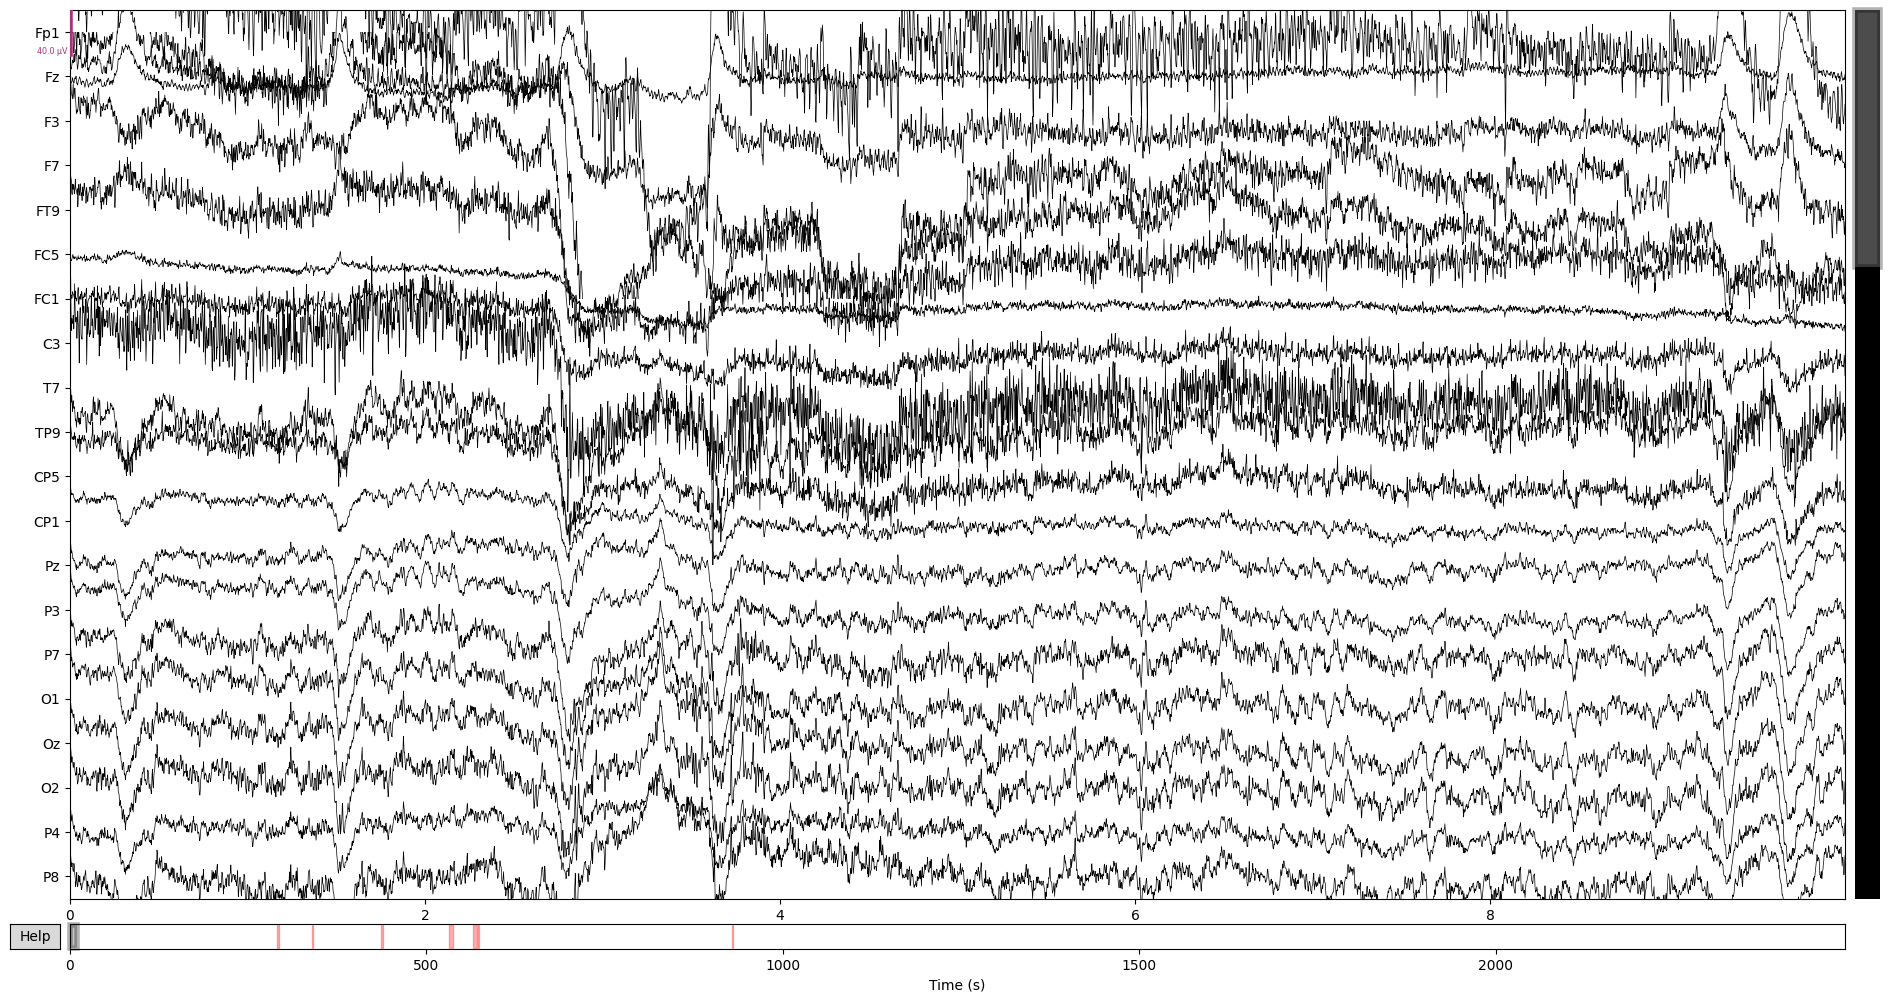

In [9]:
# Setting up annotations for bad trials: based on behavioral performance
sfreq = raw.info['sfreq']

# # Crop raw data from onset of baseline till end of adaptation
# start_samp = events[events[:, 2] == 2][0, 0]   # first baseline start
# end_samp   = events[events[:, 2] == 5][-1, 0]  # last adaptation end

# tmin = start_samp / sfreq
# tmax = end_samp / sfreq

# raw_block = raw.copy().crop(tmin=tmin, tmax=tmax)

onsets = []
durations = []
descriptions = []

for bad_trial_type in [bad_baseline, bad_adapt]:
    for trial in bad_trial_type:
        start_samp = trial[0, 0]
        end_samp   = trial[-1, 0]

        onsets.append(start_samp / sfreq)
        durations.append((end_samp - start_samp) / sfreq)
        descriptions.append('BAD')
bad_annots = mne.Annotations(onsets, durations, descriptions)

# Remove existing annotations (events are stored as np.array) and set new ones
raw.set_annotations(None)
raw.set_annotations(bad_annots)
raw.plot(events=events)


**Define timing and events for epoching**

STOPPED HERE

Figure why there's a mismatch in the events numbers by type

In [10]:
bad_baseline

[array([[145467,      0,      8],
        [146202,      0,     20],
        [146550,      0,    111],
        [146555,      0,      9]]),
 array([[169618,      0,      8],
        [170135,      0,     20],
        [170642,      0,    111],
        [170647,      0,      9]]),
 array([[218036,      0,      8],
        [219345,      0,     20],
        [219660,      0,    111],
        [219665,      0,      9]]),
 array([[265828,      0,      8],
        [266529,      0,     20],
        [267588,      0,     30],
        [268353,      0,     77],
        [268358,      0,      9]])]

In [12]:
bad_all = bad_baseline + bad_adapt
bad_events = np.vstack(bad_all)
bad_set = set(map(tuple, bad_events))
events_filtered = np.array([row for row in roi_block_events if tuple(row) not in bad_set])
events_filtered


array([[ 59752,      0,      8],
       [ 60866,      0,     20],
       [ 61975,      0,     30],
       ...,
       [639652,      0,     50],
       [639827,      0,     40],
       [640586,      0,      9]], shape=(1154, 3))

In [13]:
bad_set

{(np.int64(145467), np.int64(0), np.int64(8)),
 (np.int64(146202), np.int64(0), np.int64(20)),
 (np.int64(146550), np.int64(0), np.int64(111)),
 (np.int64(146555), np.int64(0), np.int64(9)),
 (np.int64(169618), np.int64(0), np.int64(8)),
 (np.int64(170135), np.int64(0), np.int64(20)),
 (np.int64(170642), np.int64(0), np.int64(111)),
 (np.int64(170647), np.int64(0), np.int64(9)),
 (np.int64(218036), np.int64(0), np.int64(8)),
 (np.int64(219345), np.int64(0), np.int64(20)),
 (np.int64(219660), np.int64(0), np.int64(111)),
 (np.int64(219665), np.int64(0), np.int64(9)),
 (np.int64(265828), np.int64(0), np.int64(8)),
 (np.int64(266529), np.int64(0), np.int64(20)),
 (np.int64(267588), np.int64(0), np.int64(30)),
 (np.int64(268353), np.int64(0), np.int64(77)),
 (np.int64(268358), np.int64(0), np.int64(9)),
 (np.int64(282982), np.int64(0), np.int64(8)),
 (np.int64(284733), np.int64(0), np.int64(20)),
 (np.int64(285265), np.int64(0), np.int64(111)),
 (np.int64(285270), np.int64(0), np.int64(9))

In [14]:
bad_events

array([[145467,      0,      8],
       [146202,      0,     20],
       [146550,      0,    111],
       [146555,      0,      9],
       [169618,      0,      8],
       [170135,      0,     20],
       [170642,      0,    111],
       [170647,      0,      9],
       [218036,      0,      8],
       [219345,      0,     20],
       [219660,      0,    111],
       [219665,      0,      9],
       [265828,      0,      8],
       [266529,      0,     20],
       [267588,      0,     30],
       [268353,      0,     77],
       [268358,      0,      9],
       [282982,      0,      8],
       [284733,      0,     20],
       [285265,      0,    111],
       [285270,      0,      9],
       [286366,      0,      8],
       [286726,      0,     20],
       [287100,      0,    111],
       [287105,      0,      9],
       [464336,      0,      8],
       [464904,      0,     20],
       [465218,      0,    111],
       [465223,      0,      9]])

In [20]:
# Timing between start of the trial and onset of bars AND start to end of trial
starts = events_filtered[events_filtered[:, 2] == 8][:, 0]
prepare = events_filtered[events_filtered[:, 2] == 20][:, 0]
go = events_filtered[events_filtered[:, 2] == 30][:, 0]
move_onset = events_filtered[events_filtered[:, 2] == 50][:, 0]
reach_end = events_filtered[events_filtered[:, 2] == 40][:, 0]
ends = events_filtered[events_filtered[:, 2] == 9][:, 0]

n_trials = len(starts)

timing = pd.DataFrame({
    'start_to_end': (ends - starts) / sfreq,
    'start_to_prepare': (prepare - starts) / sfreq,
    'prepare_to_go': (go - prepare) / sfreq,
    'go_to_move_onset': (move_onset - go) / sfreq,
    'move_onset_to_reach_end': (reach_end - move_onset) / sfreq,
    'reach_end_to_end': (ends - reach_end) / sfreq
})
timing.describe()

,start_to_end,start_to_prepare,prepare_to_go,go_to_move_onset,move_onset_to_reach_end,reach_end_to_end
count,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000
mean,5.600333,1.299667,1.944844,0.635417,0.203635,1.516771
std,0.729336,0.590296,0.290270,0.149778,0.104543,0.002144
min,4.286000,0.450000,1.502000,0.366000,0.116000,1.494000
25%,5.134000,0.864000,1.668000,0.534000,0.168000,1.516000
50%,5.429000,1.218000,1.935000,0.614000,0.191000,1.516000
75%,6.058000,1.602000,2.168000,0.716000,0.218000,1.518000
max,8.906000,3.620000,2.502000,1.384000,1.538000,1.522000


**Minimum timing**
- 'start_to_end': 4.29s	
- 'start_to_prepare': 0.45s **(MAYBE INCREASE?)**
- 'prepare_to_go': 1.50s
- 'go_to_move_onset': 0.37s
- 'move_onset_to_reach_end': 0.12s
- 'reach_end_to_end': 1.49s

**Minimum timing for PREPARE epochs:**
[-0.4 1.5]

**Minimum timing for GO epochs:**
[-0.4 1.5]

In [21]:
# Timing of inter-trial intervals (ITI)
intervals = np.append(np.where((starts[1:] - ends[:-1]) / sfreq <= 2,
                                (starts[1:] - ends[:-1]) / sfreq,
                                np.nan),
                      np.nan)
pd.Series(intervals).describe()


count    184.000000
mean       0.200891
std        0.001589
min        0.198000
25%        0.200000
50%        0.200000
75%        0.202000
max        0.214000
dtype: float64

_______________

**Sanity check**

Do any events ofverlap with the epochs except for target ones?

In [ ]:
# PREPARE EPOCHS: check for overlapping events
for event in events_filtered:
    if event[2] == 20:
        t0 = event[0]
        tmin = t0 - int(0.4 * sfreq)
        tmax = t0 + int(1.5 * sfreq)

        mask = (events_filtered[:, 0] >= tmin) & (events_filtered[:, 0] <= tmax) & (events_filtered[:, 0] != t0)
        overlapping = events_filtered[mask]

        print(f"\nPrepare event at {t0}:")
        print(overlapping)
        


Prepare event at 60866:
[]

Prepare event at 64001:
[]

Prepare event at 67145:
[]

Prepare event at 69822:
[]

Prepare event at 72666:
[]

Prepare event at 75718:
[]

Prepare event at 78995:
[]

Prepare event at 82339:
[]

Prepare event at 85767:
[]

Prepare event at 88894:
[]

Prepare event at 92747:
[]

Prepare event at 95991:
[]

Prepare event at 98985:
[]

Prepare event at 102365:
[]

Prepare event at 106090:
[]

Prepare event at 109267:
[]

Prepare event at 112152:
[]

Prepare event at 115246:
[]

Prepare event at 118565:
[]

Prepare event at 121684:
[]

Prepare event at 124811:
[]

Prepare event at 127930:
[]

Prepare event at 130774:
[]

Prepare event at 133779:
[]

Prepare event at 136895:
[]

Prepare event at 140139:
[]

Prepare event at 143274:
[]

Prepare event at 148537:
[]

Prepare event at 151305:
[]

Prepare event at 154424:
[]

Prepare event at 157543:
[]

Prepare event at 161037:
[]

Prepare event at 164039:
[]

Prepare event at 167183:
[]

Prepare event at 172554:
[

In [ ]:
# GO EPOCHS: check for overlapping events (30 and 40 are OK)
for event in events_filtered:
    if event[2] == 50:
        t0 = event[0]
        tmin = t0 - int(0.4 * sfreq)
        tmax = t0 + int(1.5 * sfreq)

        mask = (events_filtered[:, 0] >= tmin) & (events_filtered[:, 0] <= tmax) & (events_filtered[:, 0] != t0)
        overlapping = events_filtered[mask]

        print(f"\nGo event at {t0}:")
        print(overlapping)
        


Prepare event at 62258:
[[62333     0    40]]

Prepare event at 65561:
[[65627     0    40]]

Prepare event at 68305:
[[68396     0    40]]

Prepare event at 70931:
[[71006     0    40]]

Prepare event at 74034:
[[74100     0    40]]

Prepare event at 77144:
[[77211     0    40]]

Prepare event at 80430:
[[80488     0    40]]

Prepare event at 83891:
[[83974     0    40]]

Prepare event at 86884:
[[86943     0    40]]

Prepare event at 90012:
[[90078     0    40]]

Prepare event at 94073:
[[94156     0    40]]

Prepare event at 97350:
[[97417     0    40]]

Prepare event at 100427:
[[100502      0     40]]

Prepare event at 103705:
[[103763      0     40]]

Prepare event at 107241:
[[107332      0     40]]

Prepare event at 110510:
[[110593      0     40]]

Prepare event at 113553:
[[113628      0     40]]

Prepare event at 116514:
[[116622      0     40]]

Prepare event at 119799:
[[119883      0     40]]

Prepare event at 122893:
[[122993      0     40]]

Prepare event at 126237:
[[

ALL GOOD!

_____________________________
EPOCHING

Not setting metadata
192 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 192 events and 951 original time points ...
0 bad epochs dropped


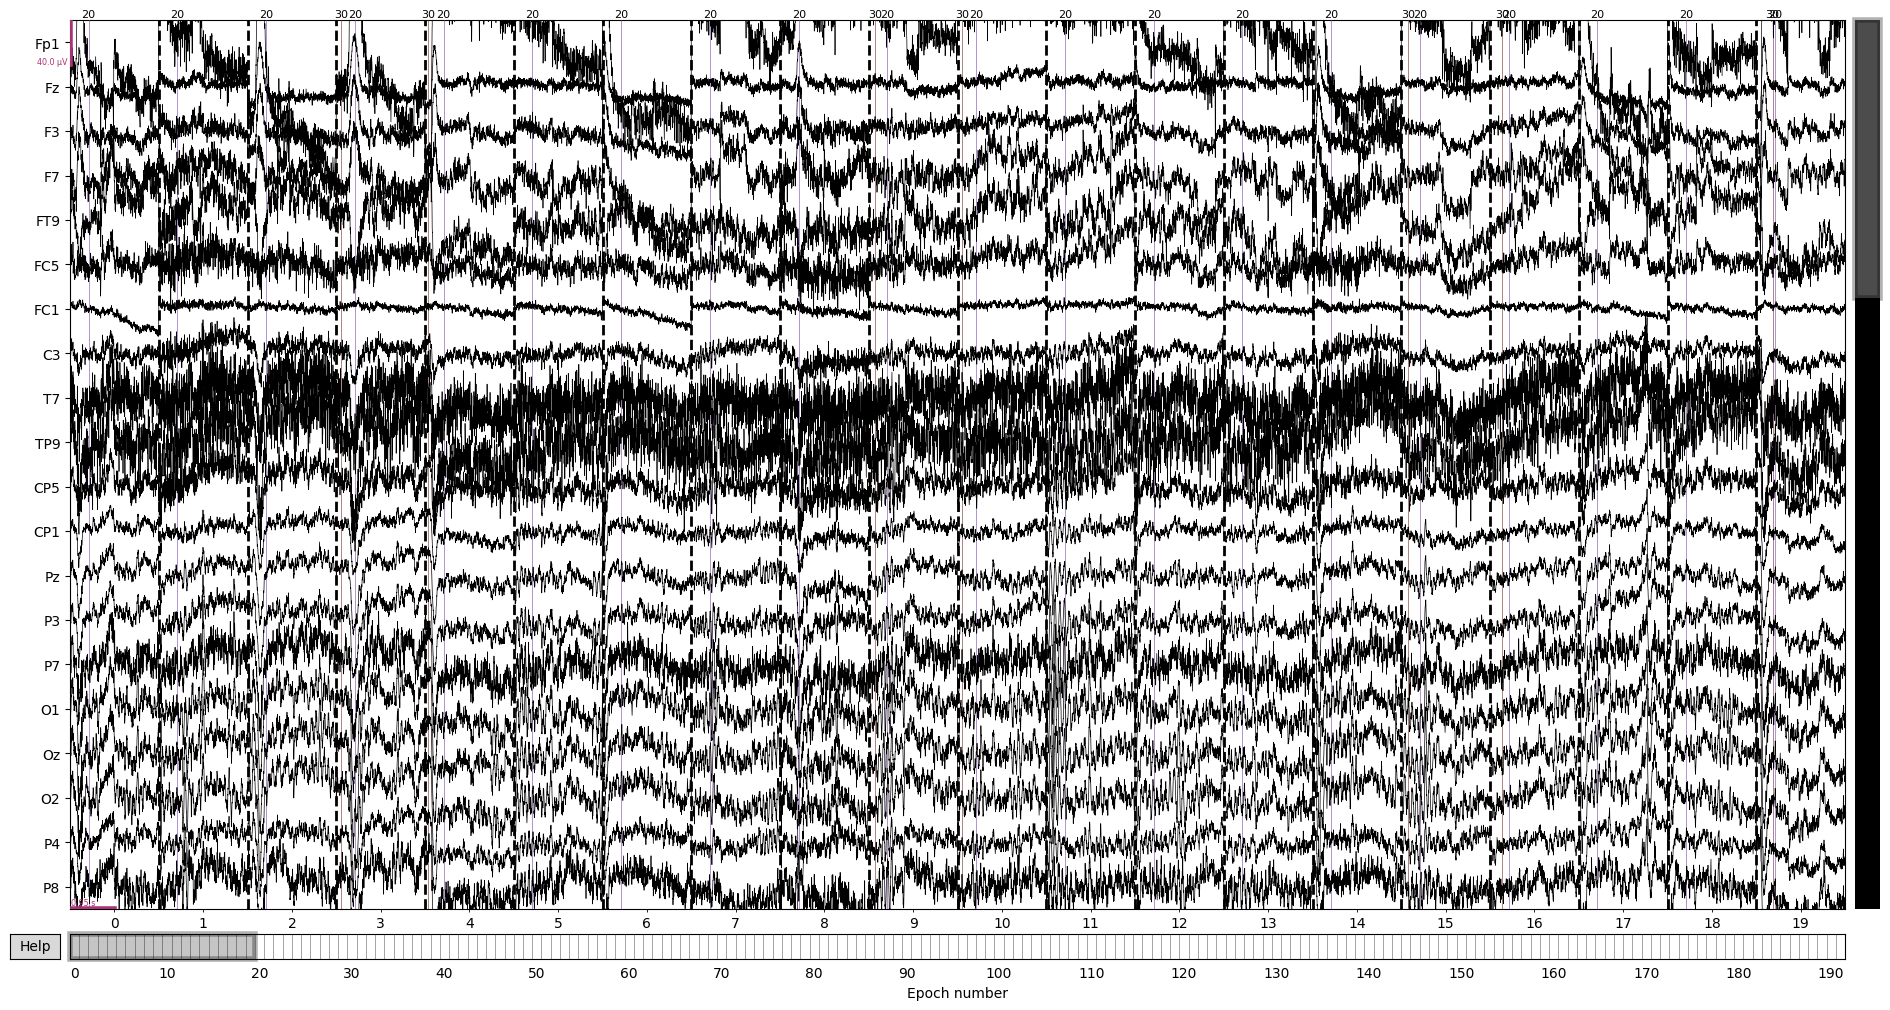

In [ ]:
# EPOCHING: PREPARE trials
events_prepare = events_filtered[events_filtered[:, 2] == 20]

event_id_prepare = {np.str_('Stimulus/S 20'): 20}
epo_tmin_prepare, epo_tmax_prepare = -0.4, 1.5

epochs_prepare = mne.Epochs(
    raw,
    events_prepare,
    event_id=event_id_prepare,
    tmin=epo_tmin_prepare,
    tmax=epo_tmax_prepare,
    baseline=(epo_tmin_prepare, 0),
    reject_by_annotation=True,
    preload=True,
)
# epochs_prepare.plot(events=events_filtered)


In [40]:
# EPOCHING: GO trials
events_go = events_filtered[events_filtered[:, 2] == 50]

event_id_go = {np.str_('Stimulus/S 50'): 50}
epo_tmin_go, epo_tmax_go = -0.4, 1.5

epochs_go = mne.Epochs(
    raw,
    events_go,
    event_id=event_id_go,
    tmin=epo_tmin_go,
    tmax=epo_tmax_go,
    baseline=(epo_tmin_go, 0),
    reject_by_annotation=True,
    preload=True,
)
# epochs_go.plot(events=events_filtered)


Not setting metadata
192 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 192 events and 951 original time points ...
0 bad epochs dropped


In [ ]:
epo_save_path = "C:\\Users\\a1902989\\Box\\Katya\\# PD project\\data_analysis\\epochs"
np.save(os.path.join(epo_save_path, f'{eeg_file_name[:-5]}_clean_events.npy'), events_filtered)
epochs_prepare.save(os.path.join(epo_save_path, f'{eeg_file_name[:-5]}_PREPARE_epochs.fif'), overwrite=True)
epochs_go.save(os.path.join(epo_save_path, f'{eeg_file_name[:-5]}_GO_epochs.fif'), overwrite=True)

C:\Users\a1902989\AppData\Local\Temp\ipykernel_33384\527396307.py:3: RuntimeWarning: This filename (D:\BonoKat\research project\# PD project\data_analysis\ARI\epochs\PDc_s1_sub00_GR_DeCRAT_PREPARE_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_prepare.save(os.path.join(epo_save_path, f'{eeg_file_name[:-5]}_PREPARE_epochs.fif'), overwrite=True)
C:\Users\a1902989\AppData\Local\Temp\ipykernel_33384\527396307.py:4: RuntimeWarning: This filename (D:\BonoKat\research project\# PD project\data_analysis\ARI\epochs\PDc_s1_sub00_GR_DeCRAT_GO_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_go.save(os.path.join(epo_save_path, f'{eeg_file_name[:-5]}_GO_epochs.fif'), overwrite=True)


[WindowsPath('D:/BonoKat/research project/# PD project/data_analysis/ARI/epochs/PDc_s1_sub00_GR_DeCRAT_GO_epochs.fif')]